In [1]:
#Loading packages
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import TNFW, NFW
import scipy.stats as stats
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import constants as const
import twopoint
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [21]:
#Loading measurements, we will focus on red galaxies
theta, xi, error, cross_term = np.loadtxt('/lsbg_des/data/gt_LSBG_combined_sources_scales_3_ran', unpack=True)
theta, xi, err_jk, cross_term = np.loadtxt('/lsbg_des/data/gt_LSBG_jackknife_combined_sources_scales_3_ran', unpack=True)
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('/lsbg_des/data/gt_LSBG_combined_sources_scales_3_red_ran', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('/lsbg_des/data/gt_LSBG_jackknife_combined_sources_scales_3_red_ran', unpack=True)
theta_blue, xi_blue, error_blue, cross_term_blue = np.loadtxt('/lsbg_des/data/gt_LSBG_combined_sources_scales_3_blue_ran', unpack=True)
theta_blue, xi_blue, err_jk_blue, cross_term_blue = np.loadtxt('/lsbg_des/data/gt_LSBG_jackknife_combined_sources_scales_3_blue_ran', unpack=True)
cov = np.loadtxt('/lsbg_des/data/jkcov_gt_LSBG_combined_sources_scales_3_red_ran')
#cov = (np.diag(err_jk_red))**2


In [4]:
#Shear model for a single NFW profile (single lens redshift, single source redshift)
def gt(zl, mass, concentration, zs, theta_rad):
    da = Planck15.angular_diameter_distance(zl)
    r_mpc = da*theta_rad
    nfw = NFW(mass, concentration, zl)
    sigma_crit = nfw.sigma_crit([zs])
    rho = nfw.profile(r_mpc)
    esd = nfw.projected_excess(r_mpc)
    gt = esd/sigma_crit
    return gt

In [5]:
#Plotting function for comparing two models to the measurements
def plot_model(model_1, model_2, label_model_1, label_model_2):
    fig, ax = plt.subplots(figsize=(7,5), ncols=1)
    plt.errorbar(theta, xi, err_jk, fmt="o", color="black", label="All Galaxies")
    plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
    plt.errorbar(theta_blue, xi_blue, err_jk_blue, fmt="o", color="royalblue", label="Blue Galaxies")
    ax.set_ylabel(r'$\Sigma(R)$ (M$_\odot$/Mpc$^2$)', fontsize=16)
    ax.plot(theta, model_1, label = str(label_model_1))
    ax.plot(theta, model_2, label = str(label_model_2))
    ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
    ax.legend(frameon=False)
    ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')

In [6]:
#Chi2 function- quantitative difference between the model and the measurements
def chi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    chi2 = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    return chi2


In [7]:
#Deltachi2 function for calculating the difference between two models
def deltachi2(err_jk, model, measurements):
    invcov = np.abs(np.linalg.inv((np.diag(err_jk))**2))
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model).T[0]-(measurements).T[0])
    deltachi2 = diff*INVCOV*diff.T
    return deltachi2

1.0


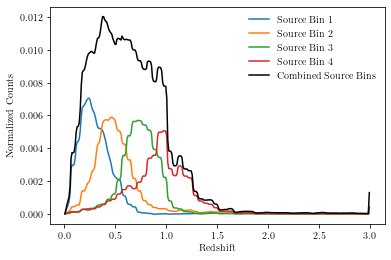

0.6297101017079711


In [8]:
#Finding mean source redshift 
T = twopoint.TwoPointFile.from_fits('/lsbg_des/data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') #Loading files
T.kernels[0].name
nzs = (T.kernels[0].nzs)
zsbin = (T.kernels[0].z)

#Weighting the source redshift bins by galaxy count
nzs_count = 24940465+25280405+24891859+25091297 #Total galaxy count
b1_weighted = (nzs[0]*24940465)/nzs_count #Weighted average for each bins
b2_weighted = (nzs[1]*25280405)/nzs_count
b3_weighted = (nzs[2]*24891859)/nzs_count
b4_weighted = (nzs[3]*25091297)/nzs_count

#Plotting the weighted source redshift bins
plt.plot(zsbin, b1_weighted, label= 'Source Bin 1')
plt.plot(zsbin, b2_weighted, label= 'Source Bin 2')
plt.plot(zsbin, b3_weighted, label= 'Source Bin 3')
plt.plot(zsbin, b4_weighted, label = 'Source Bin 4')
nzs_weighted = np.array([b1_weighted, b2_weighted, b3_weighted, b4_weighted])

A= np.trapz(np.sum(nzs_weighted, axis=0)) #Defining the normalization factor
norm_test = np.trapz(np.sum(nzs_weighted, axis=0)/A) #This should equal 1
print(norm_test)
zsdist_norm = np.sum(nzs_weighted, axis=0)/A #Defining normalized source redshift distribution
plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') #Plotting normalized source redshift distribution
plt.legend(frameon=False)
plt.xlabel('Redshift')
plt.ylabel('Normalized Counts')
plt.show()
z_mean_s = np.trapz(zsbin*zsdist_norm) #Calculating the mean source redshift
print(z_mean_s)

In [9]:
#Model Parameters
zl = 13.2e-3 #Lens Redshift (from MCMC posterior)
zl_sigma = 0.01 #Spread of lens redshift distribution
concentration = 2. #Concentration (taken from Sifon et al 2018)
zs = z_mean_s
theta_arcmin = np.geomspace(0.25, 1000, 25) #Scales of model
theta_rad = theta_arcmin/60*np.pi/180 
mass_term1 = 9.9e10 #Subhalo mass (from MCMC posterior and chi2 calculation)
mass_term2 = 12.2e14 #Host halo mass (from MCMC posterior)
offset_rad = 14/60*np.pi/180 #Scales of offset 
da = Planck15.angular_diameter_distance(zl)


In [10]:
#Shear model
def total_model(mass_term1, mass_term2, zs, zl_mean, zl_sigma, theta_rad):
    zlrange = np.linspace(zl_mean - zl_sigma, zl_mean + 3*zl_sigma, 25) #Range of lens redshift
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Lens redshift distribution
    A_zl = np.trapz(zldist) #Normalizing factor
    zldist_norm = zldist/A_zl
    
    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular to physical scales
    r_mpc = da*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW
    print(nfw_term1)
    sigma_crit = nfw_term1.sigma_crit([zs]) #Subhalo sigma_crit for a single source redshift
    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density
    gt_term1 = esd/sigma_crit #Shear calculation for 25 NFW profiles
    I_calc_term1 = np.reshape(np.trapz(gt_term1*(zldist_norm)), (25,1)) #Integrated profile with normalized lens redshift distribution
    
    da_roff = Planck15.angular_diameter_distance(zl_mean) #calculations for offset distribution
    mean_roff = np.array(offset_rad*da_roff) #
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_off_norm = r_off_dist/A_off
    
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW
    sigma_crit_term2 = nfw_term2.sigma_crit([zs]) #Host halo sigma_crit
    esd_off_dist = nfw_term2.offset_projected_excess(np.array(r_mpc), np.array(r_off_dist))
    gt_term2 = esd_off_dist[0]/sigma_crit_term2
    I_calc_term2 = np.reshape(np.trapz(gt_term2*A_off_norm*zldist_norm), (25,1)) #Integrated profile with normalized lens redshift distribution for offset
    
    total_model = I_calc_term1+I_calc_term2 #Total model calculation
    return total_model, I_calc_term1, I_calc_term2


In [11]:
#Call for model
total_model = total_model(mass_term1, mass_term2, zs, zl, zl_sigma, theta_rad)

NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 11.00
  concentration = 2.00
  redshift range = 0.00-0.04


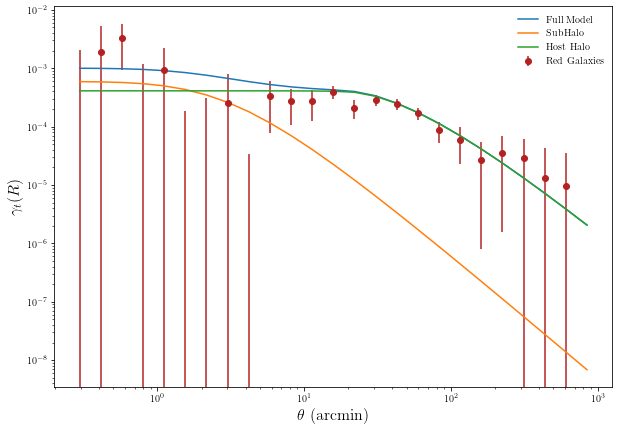

In [12]:
#Model compared to measurements
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model[0], label = 'Full Model')
ax.plot(theta, total_model[1], label = 'SubHalo')
ax.plot(theta, total_model[2], label = 'Host Halo')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')


In [13]:
#Chi2 calculation between model and measurements
chi2_total = chi2(cov, total_model[0], np.reshape(xi_red, (25,1)))
print(chi2_total)

[[109.02765584]]


In [14]:
#Distance calculations outside of the function, for the next plot
zlrange = np.linspace(zl - 1*zl_sigma, zl+3*zl_sigma, 25)
da_term = Planck15.angular_diameter_distance(zlrange)
r_mpc = da_term*theta_rad

/Users/nathaliechicoine/opt/anaconda3/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


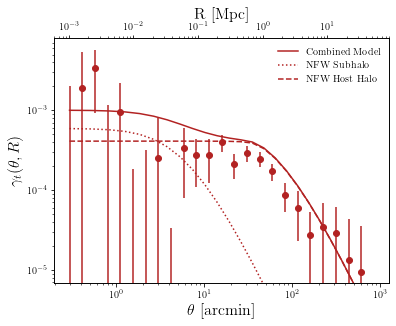

In [15]:
#Plot for measurements compared to model
fig, ax1 = plt.subplots(figsize=(6,4.5), ncols=1)
ax1.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax2 = ax1.twiny()
ax2.plot(r_mpc, total_model[0], color='firebrick', label = 'Combined Model')
ax2.plot(r_mpc, total_model[1], ls=':', color='firebrick', label='NFW Subhalo')
ax2.plot(r_mpc, total_model[2],ls='--', color='firebrick',label='NFW Host Halo')

ax1.set_ylabel(r'$\gamma_t(\theta, R)$', fontsize=16)
#ax2.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax1.set_xlabel('$\\theta$ [arcmin]', fontsize=16)
ax2.set_xlabel('R [Mpc]', fontsize=16)

ax2.legend(frameon=False)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.savefig('lsbg_model_measurements.png', dpi=300, bbox_inches='tight')
plt.savefig('lsbg_model_measurements.pdf', dpi=300, bbox_inches='tight')


In [16]:
#Density Profile Function- we use the projected surface density instead of the excess surface density
def density_profile(mass_term1, mass_term2, zl_mean, zs, zl_sigma):
    #Setting up lens redshift distribution
    zlrange = np.linspace(zl_mean - 1*zl_sigma, zl_mean+ 3*zl_sigma, 25)
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma)
    A_zl = np.trapz(zldist)
    norm_test_zl = np.trapz(zldist/A_zl)
    zldist_norm = zldist/A_zl
 
    da_term = Planck15.angular_diameter_distance(zlrange)
    r_mpc_term = da_term*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange)
    sigma_term1 = nfw_term1.projected(r_mpc_term) #Projected surface density
    I_calc_sigma_term1 = np.reshape((np.trapz(sigma_term1)*zldist_norm), (25,1))
    
    mean_roff = np.array(offset_rad*da)
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_norm = r_off_dist/A_off
    
    nfw_term2 = NFW(mass_term2, concentration, zlrange)
    sigma_term2 = nfw_term2.offset_projected(np.array(r_mpc_term), np.array(r_off_dist))[0] #projected surface density
    I_calc_sigma_term2 = np.reshape((np.trapz(sigma_term2)*A_norm*zldist_norm), (25,1))
    return I_calc_sigma_term1, I_calc_sigma_term2
    

In [17]:
sigma_term1 = density_profile(mass_term1, mass_term2, zl, zs, zl_sigma)[0]
sigma_term2 = density_profile(mass_term1, mass_term2, zl, zs, zl_sigma)[1]

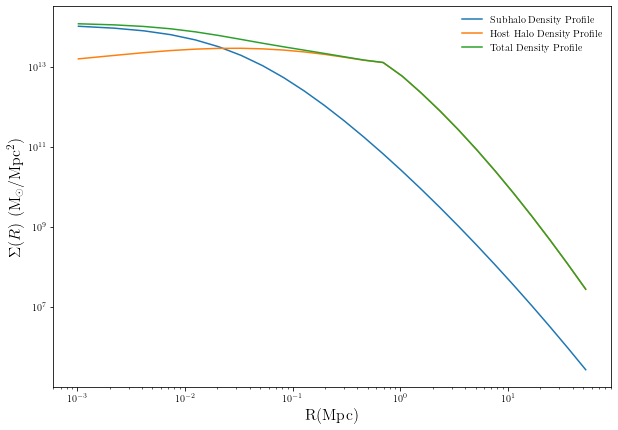

In [18]:
#Plot Density Profiles
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
ax.plot(r_mpc, sigma_term1, label = 'Subhalo Density Profile' )
ax.plot(r_mpc, sigma_term2, label = 'Host Halo Density Profile')
ax.plot(r_mpc, sigma_term1+sigma_term2, label = 'Total Density Profile')
ax.set_ylabel(r'$\Sigma(R)$ (M$_\odot$/Mpc$^2$)', fontsize=16)
ax.set_xlabel('R(Mpc)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')